Jupyter Notebook for Us Political Book Network

In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Input, Model, layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from sklearn.preprocessing import StandardScaler
import skfuzzy as fuzz
from copy import deepcopy
import json
import numpy as np
from scipy.linalg import fractional_matrix_power
import matplotlib.pyplot as plt
import pickle
import networkx as nx
import os

In [36]:
# Create the graph (example using networkx)
G = nx.read_gml('polbooks.gml')  # Load the Dolphin network if available or replace with appropriate graph loading method
node_names = np.array(list(G.nodes()))
print(node_names)
# Adjacency matrix
A = nx.adjacency_matrix(G).toarray()

# Adding self-loops
A = A + np.eye(G.number_of_nodes())

# Degree matrix
D = np.diag(np.sum(A, axis=1))

# Compute D^-0.5
D_half_norm = fractional_matrix_power(D, -0.5)

# Feature matrix initialization (simple identity matrix in this example)
E = np.eye(G.number_of_nodes())
C = np.eye(G.number_of_nodes())  # This is just a placeholder, replace or modify as per actual features
X = np.concatenate((E, C), axis=1)

# Graph convolution operation
X = D_half_norm.dot(A).dot(D_half_norm).dot(X)

['1000 Years for Revenge' 'Bush vs. the Beltway' "Charlie Wilson's War"
 'Losing Bin Laden' 'Sleeping With the Devil' 'The Man Who Warned America'
 'Why America Slept' 'Ghost Wars' 'A National Party No More'
 'Bush Country' 'Dereliction of Duty' 'Legacy' 'Off with Their Heads'
 'Persecution' "Rumsfeld's War" 'Breakdown' 'Betrayal' 'Shut Up and Sing'
 'Meant To Be' 'The Right Man' 'Ten Minutes from Normal'
 "Hillary's Scheme" 'The French Betrayal of America'
 'Tales from the Left Coast' 'Hating America' 'The Third Terrorist'
 'Endgame' 'Spin Sisters' "All the Shah's Men" 'Dangerous Dimplomacy'
 'The Price of Loyalty' 'House of Bush, House of Saud'
 'The Death of Right and Wrong' 'Useful Idiots' "The O'Reilly Factor"
 'Let Freedom Ring' 'Those Who Trespass' 'Bias' 'Slander'
 'The Savage Nation' 'Deliver Us from Evil' 'Give Me a Break'
 'The Enemy Within' 'The Real America' "Who's Looking Out for You?"
 'The Official Handbook Vast Right Wing Conspiracy' 'Power Plays'
 'Arrogance' 'The Per

Define the variational autoencoder

In [37]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, A, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.A = A
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.architecture_loss_tracker = keras.metrics.Mean(
            name="architecture_loss"
        )

    def call(self, inputs):
      mean, log_var, x = self.encoder(inputs)
      x = self.decoder(x)
      return x

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.architecture_loss_tracker
        ]
    def predict(self, data):
       z_mean, z_log_var, z = self.encoder(data)
       output = self.decoder(z)
       return output

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #reconstruction_loss = tf.reduce_mean(
            #    tf.reduce_sum(
            #        keras.losses.mean_absolute_error(data, reconstruction), axis=(1, 2)
            #    )
            #)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.square(data-reconstruction), axis=(1)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            architecture_loss = tf.reduce_mean(tf.square(self.A - tf.matmul(z,z,transpose_b=True)))
            total_loss = reconstruction_loss + kl_loss + architecture_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.architecture_loss_tracker.update_state(architecture_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "architecture_loss": self.architecture_loss_tracker.result()
        }

Define hyperparameters

In [38]:
nFeatures = X.shape[1]
nEmbeddings = 2
nEpochs = 8000
learningRate = 0.001
optimizer = Adam(learningRate)
batchSize = X.shape[0]

Process feature matrix

In [39]:
scaler = StandardScaler()
scaledX = scaler.fit_transform(X)

Define VAE's architecture

In [40]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

print(nFeatures)
input_encoder = Input(shape=(nFeatures, ))
nNeurons = nFeatures // 2
x = Dense(nNeurons, activation='tanh')(input_encoder)
nNeurons = nNeurons // 2
while(nNeurons >= nEmbeddings * 2):
  x = Dense(nNeurons, activation='tanh')(x)
  nNeurons = nNeurons // 2
z_mean = Dense(nEmbeddings, name="z_mean")(x)
z_log_var = Dense(nEmbeddings, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

input_decoder = Input(shape=(nEmbeddings, ))
nNeurons = nEmbeddings * 2
x = Dense(nNeurons, activation='tanh')(input_decoder)
nNeurons = nNeurons * 2
while(nNeurons <= nFeatures // 2):
  x = Dense(nNeurons, activation='tanh')(x)
  nNeurons = nNeurons * 2
recon = Dense(nFeatures)(x)
encoder = Model(input_encoder, [z_mean, z_log_var, z], name="encoder")
decoder = Model(input_decoder, recon, name="decoder")
vae = VAE(encoder, decoder, A)
vae.compile(optimizer=optimizer)
vae.built = True

210


In [41]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 16)             │           144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 210)            │        13,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,502 (64.46 KB)

 Trainable params: 16,502 (64.46 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
vae.encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 210)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_22 (Dense)    │ (None, 105)       │     22,155 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_23 (Dense)    │ (None, 52)        │      5,512 │ dense_22[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_24 (Dense)    │ (None, 26)        │      1,378 │ dense_23[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_25 (Dense)    │ (None, 13)        │        351 │ dense_24[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_26 (Dense)    │ (None, 6)         │         84 │ dense_25[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │         14 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │         14 │ dense_26[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling_1          │ (None, 2)         │          0 │ z_mean[0][0],     │
│ (Sampling)          │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 29,508 (115.27 KB)

 Trainable params: 29,508 (115.27 KB)

 Non-trainable params: 0 (0.00 B)

Train VAE

In [43]:
hist_vae = vae.fit(X, epochs = nEpochs, batch_size=batchSize, verbose =False)

In [72]:
vae.save_weights(os.getcwd()+'/vae_polbooks' + '.weights.h5')
vae.load_weights(os.getcwd()+'/vae_polbooks' + '.weights.h5')

dict_keys(['architecture_loss', 'reconstruction_loss', 'total_loss'])


Text(0, 0.5, 'Architecture loss')

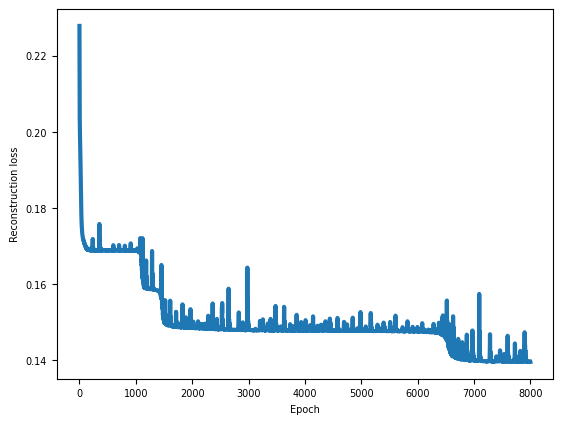

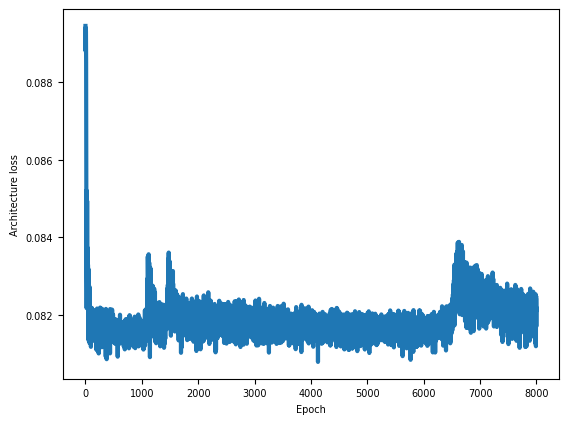

In [73]:
print(hist.history.keys())
x_range = range(len(hist.history['reconstruction_loss']))
plt.plot(x_range, hist.history['reconstruction_loss'])
plt.xlabel('Epoch')
plt.ylabel('Reconstruction loss')
plt.figure()
plt.plot(x_range, hist.history['architecture_loss'])
plt.xlabel('Epoch')
plt.ylabel('Architecture loss')

In [84]:
_,_,Z = vae.encoder(X)

Apply c-means

In [102]:
from sklearn.metrics import silhouette_score

In [163]:
maxNCenters = 100
m = 10
losses = []
memberships = []
centroids = []
silhouette_scores = []
for nCenters in range(2,maxNCenters+1):
  cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
          Z.numpy().T, nCenters, m, error=0.005, maxiter=1000, init=None)
  memberships.append(u)
  centroids.append(cntr)
  sse = 0
  for i in range(len(Z)):
    zLoc = np.asarray(Z[i])
    for j in range(nCenters):
      cLoc = np.asarray(cntr[j])
      sse += u[j][i] * np.sum(np.square(zLoc - cLoc))
  losses.append(sse)
  hard_clusters = np.argmax(u, axis=0)
  silhouette_scores.append(silhouette_score(Z, hard_clusters))
  #losses.append(np.mean(np.square(d)))
with open(os.getcwd() + '/memberships_polbooks/' + f'_m={m}.pkl','wb') as f:
  pickle.dump([memberships, centroids], f)

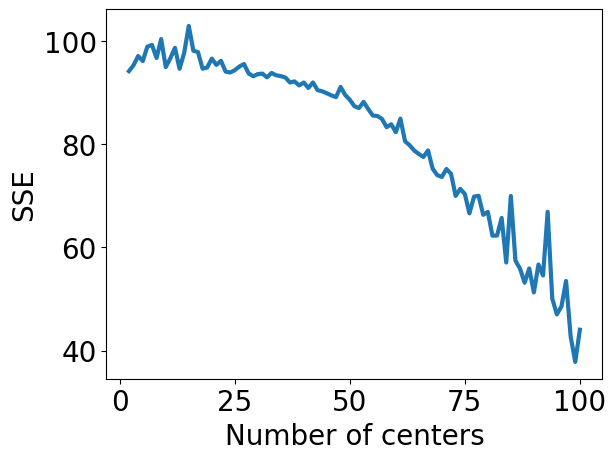

In [164]:
x_range = [i for i in range(2,maxNCenters+1)]
#plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 20, 'lines.linewidth':3})
plt.plot(x_range,losses)
plt.xlabel("Number of centers")
plt.ylabel("SSE")
#plt.xticks(x_range, rotation=45)
#plt.grid(True)
plt.savefig('/Users/ashfak/Downloads/politicalbooks/'+ f'political_sse_cmeans_m={m}.png', dpi=450, bbox_inches = "tight")

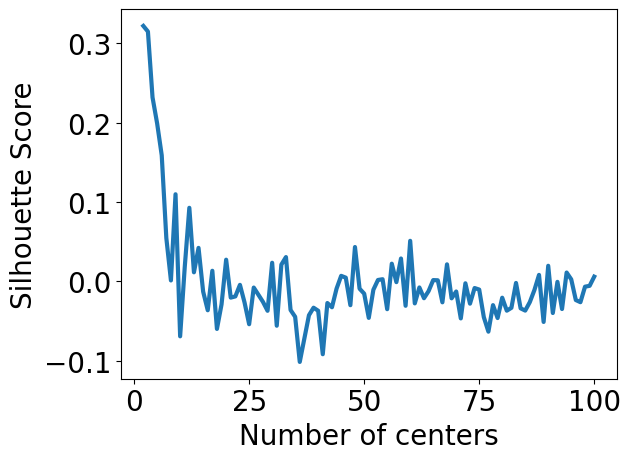

In [165]:
x_range = [i for i in range(2,maxNCenters+1)]
#plt.figure(figsize=(12, 6))
plt.rcParams.update({'font.size': 20, 'lines.linewidth':3})
plt.plot(x_range,silhouette_scores)
plt.xlabel('Number of centers')
plt.ylabel('Silhouette Score')
#plt.xticks(x_range, rotation=45)
#plt.grid(True)
plt.savefig('/Users/ashfak/Downloads/politicalbooks/'+ f'political_sils_cmeans_m={m}.png', dpi=450, bbox_inches = "tight")

In [166]:
n_clusters = 20
members = [[] for i in range(n_clusters)]
members_classes = [[] for i in range(n_clusters)]
clusters = np.argmax(memberships[n_clusters-2].T, axis = 1)
print(node_names)
node_names_array = np.array(node_names)
for i in range(len(clusters)):
  members[clusters[i]].append(i)
  members_classes[clusters[i]].append(node_names[i])

['1000 Years for Revenge' 'Bush vs. the Beltway' "Charlie Wilson's War"
 'Losing Bin Laden' 'Sleeping With the Devil' 'The Man Who Warned America'
 'Why America Slept' 'Ghost Wars' 'A National Party No More'
 'Bush Country' 'Dereliction of Duty' 'Legacy' 'Off with Their Heads'
 'Persecution' "Rumsfeld's War" 'Breakdown' 'Betrayal' 'Shut Up and Sing'
 'Meant To Be' 'The Right Man' 'Ten Minutes from Normal'
 "Hillary's Scheme" 'The French Betrayal of America'
 'Tales from the Left Coast' 'Hating America' 'The Third Terrorist'
 'Endgame' 'Spin Sisters' "All the Shah's Men" 'Dangerous Dimplomacy'
 'The Price of Loyalty' 'House of Bush, House of Saud'
 'The Death of Right and Wrong' 'Useful Idiots' "The O'Reilly Factor"
 'Let Freedom Ring' 'Those Who Trespass' 'Bias' 'Slander'
 'The Savage Nation' 'Deliver Us from Evil' 'Give Me a Break'
 'The Enemy Within' 'The Real America' "Who's Looking Out for You?"
 'The Official Handbook Vast Right Wing Conspiracy' 'Power Plays'
 'Arrogance' 'The Per

In [167]:
file = open(os.getcwd()  + '/list_clusters_polbooks/'+'_'+ str(n_clusters) + f'_no_redundancy_m={m}.json','w')
file.write(json.dumps(members_classes))
file.close()

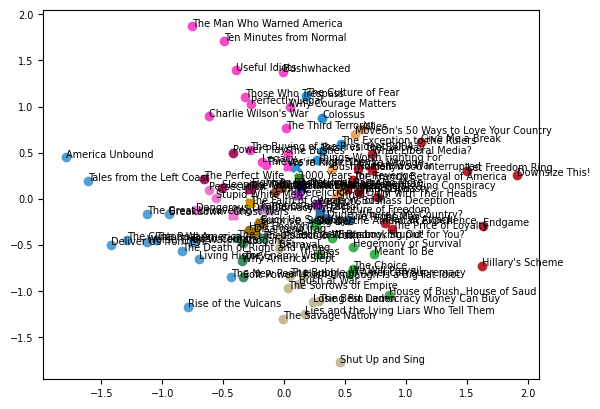

In [168]:
import random
y = [[] for i in range(n_clusters)]
x = [[] for i in range(n_clusters)]
centroid_y = []
centroid_x = []
hexadecimal_alphabets = '0123456789ABCDEF'
colors = ["#" + ''.join([random.choice(hexadecimal_alphabets) for j in range(6)]) for i in range(n_clusters)]
# colors = ['red','green','blue','purple','orange', 'black', 'gray', 'pink', 'yellow', 'navy']
for i in range(n_clusters):
  for j in members[i]:
    y[i].append(Z[j][1])
    x[i].append(Z[j][0])
  centroid_y.append(centroids[n_clusters-2][i][1])
  centroid_x.append(centroids[n_clusters-2][i][0])
# plt.axis('off')
plt.rcParams.update({'font.size': 7, 'lines.linewidth':3})
for i in range(n_clusters):
  plt.scatter([centroid_x[i]], [centroid_y[i]], color=colors[i],marker='x')
  plt.scatter(x[i], y[i], color=colors[i])
  for j in range(len(x[i])):
     plt.text(x[i][j], y[i][j], members_classes[i][j])
plt.savefig('/Users/ashfak/Downloads/politicalbooks/' + f'political_scatter_no_redundancy_m={m}.png', dpi=450, bbox_inches = "tight")

In [100]:
thresholds = []
i = 0.1
while(i <= 0.5):
  thresholds.append(round(i,2))
  i += 0.05
set_members = []
for threshold in thresholds:
  tmp_members = deepcopy(members)
  tmp_members_classes = deepcopy(members_classes)
  for inx, membership in enumerate(memberships[n_clusters-2]):
    for inx2, score in enumerate(membership):
      if(score >=  threshold and inx2 not in tmp_members[inx]):
        tmp_members[inx].append(inx2)
        tmp_members_classes[inx].append(node_names_array[inx2])
  set_members.append(tmp_members_classes)
  file = open(os.getcwd() + '/list_clusters_polbooks/'+'_' + str(n_clusters) + f'_redundancy_m={m}_' + str(threshold) + '.json','w')
  file.write(json.dumps(tmp_members_classes))
  file.close()

In [57]:
for lst in set_members[4]:
  print(len(lst))

2
13
3
2
4
6
8
1
2
2
6
6
16
6
15
5
1
3
1
3


In [54]:
for member in members:
  print(len(member))

2
13
3
2
4
6
8
1
2
2
6
6
16
6
15
5
1
3
1
3


In [55]:
print(memberships[0][0])

[0.47871194 0.45282895 0.46228054 0.65399645 0.53163205 0.52541472
 0.4603141  0.51031438 0.47632504 0.49299373 0.48087402 0.54133057
 0.47628186 0.53760564 0.43012167 0.47012839 0.44712881 0.51746263
 0.4926009  0.63380697 0.54217439 0.43887456 0.43607036 0.48254183
 0.52373148 0.47638135 0.47780428 0.54011803 0.52210927 0.47197087
 0.47419485 0.53593252 0.54889514 0.5119141  0.51580089 0.4582143
 0.48739055 0.53449346 0.51932905 0.45985831 0.50763697 0.49021251
 0.47483043 0.55207771 0.47665792 0.47837351 0.51438778 0.52534678
 0.46781301 0.45672332 0.54245164 0.54030885 0.5984339  0.47755239
 0.53444602 0.46375207 0.53137293 0.53230254 0.53792855 0.49016002
 0.51768219 0.45667916 0.53512087 0.55341782 0.52368016 0.45491517
 0.50221582 0.46918994 0.52315779 0.48269524 0.46428979 0.51729497
 0.52773381 0.53487151 0.53254394 0.45338615 0.51056233 0.46760234
 0.49465101 0.5562064  0.46478581 0.48511842 0.52029424 0.56563395
 0.43905633 0.52235935 0.51781514 0.50928964 0.52410909 0.47918